In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(8,6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import scipy.io as sio

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(1)

import seaborn as sns
import pandas as pd
from astropy.io import fits

sns.set(font_scale=2)
sns.set_style("white", {"axes.grid": "False"})
sns.set_style("ticks")

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import joypy

# Step 1: import catalogs and galaxy IDs [and flags]

In [2]:
# SEDs in magnitudes
candels_cat_small = np.loadtxt('../catalogs/CANDELS_GDSS_workshop.dat')

# subtracting 1 from the ID for python indexing
cat_small_ids = candels_cat_small[0:,0] - 1
cat_small_z = candels_cat_small[0:,1]

print(str(cat_small_z.shape[0])+' galaxies in the small catalog.')

#------------------------------------------------------------------------------

candels_cat_z1 = np.loadtxt('../catalogs/CANDELS_GDSS_workshop_z1.dat')

# subtracting 1 from the ID for python indexing
cat_z1_ids = candels_cat_z1[0:,0] - 1
cat_z1_z = candels_cat_z1[0:,1]
print(str(cat_z1_z.shape[0])+' galaxies in the z~1 catalog.')

#------------------------------------------------------------------------------

candels_cat_z3 = np.loadtxt('../catalogs/CANDELS_GDSS_workshop_z3.dat')

# subtracting 1 from the ID for python indexing
cat_z3_ids = candels_cat_z3[0:,0] - 1
cat_z3_z = candels_cat_z3[0:,1]

print(str(cat_z3_z.shape[0])+' galaxies in the z~3 catalog.')

z1flag_cat = np.genfromtxt('../catalogs/flags_z1.dat')
z1flag_ids = z1flag_cat[0:,0]

z1_mask = np.zeros_like(cat_z1_ids)
for i in range(len(z1flag_ids)):
    z1_mask[cat_z1_ids == z1flag_ids[i]-1 ] = 1
    
z3flag_cat = np.genfromtxt('../catalogs/flags_z3.dat')
z3flag_ids = z3flag_cat[0:,0]

z3_mask = np.zeros_like(cat_z3_ids)
for i in range(len(z3flag_ids)):
    z3_mask[cat_z3_ids == z3flag_ids[i]-1 ] = 1

23 galaxies in the small catalog.
371 galaxies in the z~1 catalog.
161 galaxies in the z~3 catalog.


# Step 2: import outputs of all the SED fitting codes.

In [3]:
%run import_scripts/import_p16_fits.py
%run import_scripts/import_dense_basis_fits.py
%run import_scripts/import_fitsed_fits.py
%run import_scripts/import_nima_lephare_fits.py
%run import_scripts/import_marianna_zphot_fits.py
%run import_scripts/import_prospector_fits.py
%run import_scripts/import_bagpipes_fits.py
%run import_scripts/import_cigale_fits_2020.py
%run import_scripts/import_interrogator_fits.py
%run import_scripts/import_speedyMC_fits.py
%run import_scripts/import_eazy_fits.py
%run import_scripts/import_magphys_fits.py
%run import_scripts/import_beagle_fits.py
%run import_scripts/import_sed3fit_fits.py

imported pacifici+16 fits.
imported dense basis fits.
imported FITSED (salmon+15?) fits.
imported Nima's LePhare fits.
imported Marianna's (zPhot) fits.
imported Prospector fits.
imported bagpipes fits.
imported CIGALE files (z=1 fits from Oct 2020, z=3 fits from 27 Feb 2019)
imported interrogator fits.
imported SpeedyMC fits.
imported eazy fits.
imported magphys fits.
imported beagle fits.
imported SED3fit fits.


# Step 3: Take everyone's data and put it in a dataframe, then start the visualization and analysis.

## define dataframes below for Mass, SFR and dust at z~1. Change the dictionary labels here to change the x-tick labels in the violin- and box-plots.

In [4]:
##need to put the codes in alphabetical order

brett_mass_z1_masked = brett_mass_z1
brett_mass_z1_masked[brett_mass_z1_masked < 0] = np.nan

nima_mass_z1_masked = nima_mass_z1
nima_mass_z1_masked[nima_mass_z1_masked < 0] = np.nan

z1_cat_mass_dict = {
                    'Bagpipes': bagpipes_mass_z1, 
                    'Beagle': beagle_mass_z1,
                    'Cigale':cigale_mass, 
                    'Dense Basis': DB_mass_z1.ravel(), 
                    'FITSED':brett_mass_z1_masked, 
                    'Interrogator':interrogator_mass_z1_pegase.ravel(),
                    'LePhare':nima_mass_z1_masked, 
                    'MAGPHYS':magphys_mass_z1, 
                    'Pacifici+16': cami_mass_z1.ravel(), 
                    'Prospector': prospector_mass_z1.ravel(),
                    'SED3FIT':sed3fit_mass_z1,
                    'SpeedyMC':speedy_mass_z1,
                    'zPhot':marianna_mass_z1}
z1_cat_mass = pd.DataFrame(data=z1_cat_mass_dict)

z1_cat_mass[z1_cat_mass < 7] = np.nan

#-----------------------------------------------------------------------
# getting mass uncertainties as well


nima_mass_uncert_z1_masked = nima_mass_hi_z1 - nima_mass_lo_z1
nima_mass_uncert_z1_masked[nima_mass_z1 < 0] = np.nan

brett_mass_uncert_z1_masked = brett_mass_hi_z1 - brett_mass_lo_z1
brett_mass_uncert_z1_masked[brett_mass_z1 < 0] = np.nan
#brett_mass_uncert_z1_masked[brett_mass_uncert_z1_masked > 1] = np.nan

z1_cat_mass_uncert_dict = {
                    'Bagpipes': bagpipes_mass_hi_z1 - bagpipes_mass_lo_z1, 
                    'Beagle': beagle_mass_hi_z1 - beagle_mass_lo_z1,
                    'Cigale': cigale_mass_err*2, 
                    'Dense Basis': DB_mass_hi_z1 - DB_mass_lo_z1, 
                    'FITSED':brett_mass_uncert_z1_masked, 
                    'Interrogator':(interrogator_mass_z1_hi_pegase.ravel() - interrogator_mass_z1_lo_pegase.ravel()),
                    'LePhare':nima_mass_uncert_z1_masked, 
                    'MAGPHYS':magphys_mass_hi_z1 - magphys_mass_lo_z1, 
                    'Pacifici+16': cami_mass_hi_z1 - cami_mass_lo_z1, 
                    'Prospector': (prospector_mass_hi_z1.ravel() - prospector_mass_lo_z1.ravel()),
                    'SED3FIT':sed3fit_mass_z1_high - sed3fit_mass_z1_low,
                    'SpeedyMC':speedy_mass_hi_z1 - speedy_mass_lo_z1,
                    'zPhot':marianna_mass_hi_z1 - marianna_mass_lo_z1} 
z1_cat_mass_uncert = pd.DataFrame(data=z1_cat_mass_uncert_dict)

z1_cat_mass_uncert[z1_cat_mass < 7] = np.nan
z1_cat_mass_uncert[z1_cat_mass_uncert > 2] = np.nan



#-----------------------------------------------------------------------

z1_cat_sfr_dict = {
                    'Bagpipes': bagpipes_sfr_z1, 
                    'Beagle': beagle_sfr_z1,
                    'Cigale':cigale_sfr, 
                    'Dense Basis': DB_sfr_z1.ravel(), 
                    'FITSED':brett_sfr_z1, 
                    'Interrogator':interrogator_sfr_z1_pegase,
                    'LePhare':nima_sfr_z1, 
                    'MAGPHYS':magphys_sfr_z1, 
                    'Pacifici+16': cami_sfr_z1.ravel(), 
                    'Prospector': prospector_sfr_z1.ravel(),
                    'SED3FIT':sed3fit_sfr_z1,
                    'SpeedyMC':speedy_sfr_z1,
                    'zPhot':marianna_sfr_z1} 
z1_cat_sfr = pd.DataFrame(data=z1_cat_sfr_dict)

z1_cat_sfr[z1_cat_sfr < -3] = -3 # fixes the stretching that a lot of the SFR distributions show due to exrtemely low SFRs


#-----------------------------------------------------------------------
# getting sfr uncertainties as well


nima_sfr_uncert_z1_masked = nima_sfr_hi_z1 - nima_sfr_lo_z1
nima_sfr_uncert_z1_masked[nima_sfr_z1 < 0] = np.nan

brett_sfr_uncert_z1_masked = brett_sfr_hi_z1 - brett_sfr_lo_z1
brett_sfr_uncert_z1_masked[brett_sfr_z1 < 0] = np.nan
#brett_sfr_uncert_z1_masked[brett_sfr_uncert_z1_masked > 1] = np.nan

z1_cat_sfr_uncert_dict = {
                    'Bagpipes': bagpipes_sfr_hi_z1 - bagpipes_sfr_lo_z1, 
                    'Beagle': beagle_sfr_hi_z1 - beagle_sfr_lo_z1,
                    'Cigale':cigale_sfr_err*2, 
                    'Dense Basis': DB_sfr_hi_z1 - DB_sfr_lo_z1, 
                    'FITSED':brett_sfr_uncert_z1_masked, 
                    'Interrogator':(interrogator_sfr_z1_hi_pegase.ravel() - interrogator_sfr_z1_lo_pegase.ravel()),
                    'LePhare':nima_sfr_uncert_z1_masked, 
                    'MAGPHYS':magphys_sfr_hi_z1 - magphys_sfr_lo_z1, 
                    'Pacifici+16': cami_sfr_hi_z1 - cami_sfr_lo_z1, 
                    'Prospector': (prospector_sfr_hi_z1.ravel() - prospector_sfr_lo_z1.ravel()),
                    'SED3FIT':sed3fit_sfr_z1_high - sed3fit_sfr_z1_low,
                    'SpeedyMC':speedy_sfr_hi_z1 - speedy_sfr_lo_z1,
                    'zPhot':marianna_sfr_hi_z1 - marianna_sfr_lo_z1} 
z1_cat_sfr_uncert = pd.DataFrame(data=z1_cat_sfr_uncert_dict)

z1_cat_sfr_uncert[z1_cat_mass < 7] = np.nan
z1_cat_sfr_uncert[z1_cat_sfr_uncert > 2] = np.nan
z1_cat_sfr_uncert = np.abs(z1_cat_sfr_uncert)


#-----------------------------------------------------------------------


interrogator_Av_z1_pegase[interrogator_Av_z1_pegase < 0] = np.nan

z1_cat_Av_dict = {
                    'Bagpipes': bagpipes_Av_z1, 
                    'Beagle': beagle_Av_z1,
                    'Cigale':cigale_Av, 
                    'Dense Basis': DB_Av_z1.ravel(), 
                    'FITSED':brett_Av_z1, 
                    'Interrogator':interrogator_Av_z1_pegase,
                    'LePhare':nima_Av_z1, 
                    'MAGPHYS':magphys_Av_z1, 
                    'Pacifici+16': cami_Av_z1.ravel(), 
                    'Prospector': prospector_Av_z1.ravel(),
                    'SED3FIT':sed3fit_av_z1,
                    'SpeedyMC':speedy_Av_z1,
                    'zPhot':marianna_Av_z1} 
z1_cat_Av = pd.DataFrame(data=z1_cat_Av_dict)



#-----------------------------------------------------------------------


interrogator_Av_z1_pegase[interrogator_Av_z1_pegase < 0] = np.nan

z1_cat_Av_uncert_dict = {
                    'Bagpipes': (bagpipes_Av_hi_z1 - bagpipes_Av_lo_z1), 
                    'Beagle': (beagle_Av_hi_z1 - beagle_Av_lo_z1),
                    'Cigale':cigale_Av_err*2, 
                    'Dense Basis': (DB_Av_hi_z1.ravel() - DB_Av_lo_z1.ravel()), 
                    'FITSED':(brett_Av_hi_z1 - brett_Av_lo_z1), 
                    'Interrogator':(interrogator_Av_z1_hi_pegase - interrogator_Av_z1_lo_pegase),
                    'LePhare':np.ones_like(nima_Av_z1)*np.nan, 
                    'MAGPHYS':(magphys_Av_hi_z1 - magphys_Av_lo_z1), 
                    'Pacifici+16': (cami_Av_hi_z1.ravel() - cami_Av_hi_z1.ravel()), 
                    'Prospector': (prospector_Av_hi_z1.ravel() - prospector_Av_lo_z1.ravel()),
                    'SED3FIT':(sed3fit_av_z1_high - sed3fit_av_z1_low),
                    'SpeedyMC':(speedy_Av_hi_z1 - speedy_Av_lo_z1),
                    'zPhot':np.ones_like(marianna_Av_z1)*np.nan} 
z1_cat_Av_uncert = pd.DataFrame(data=z1_cat_Av_uncert_dict)



print(z1_cat_mass.shape)
print(z1_cat_sfr.shape)
print(z1_cat_Av.shape)

(371, 13)
(371, 13)
(371, 13)


# make (and save) plots: 

# z=1 | M$_*$, SFR, A$_V$ distribution [violin plots]

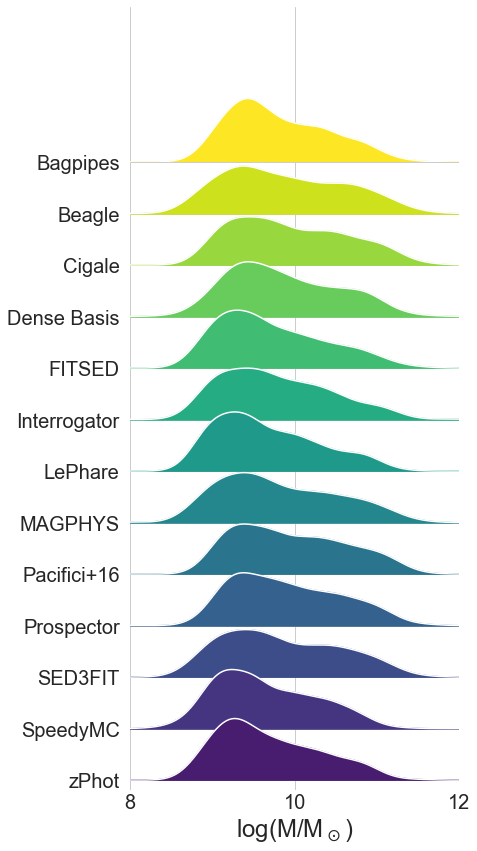

In [19]:
fig, axes = joypy.joyplot(data = z1_cat_mass[z1_mask == 0],linecolor='w',ylabels=True, xlabelsize=20, ylabelsize=20,
                        figsize=(7,12),grid=True,yrot=0,colormap=matplotlib.cm.viridis_r)
for i in range(len(axes)):
    tempy = axes[i].set_ylim()
    axes[i].set_ylim(tempy[0],tempy[1]+1.0)
    axes[i].set_xlim(8,12)
plt.xlabel(r'log(M/M$_\odot$)')

plt.savefig("../figures/fig4_distrib_z1_mass.png", dpi=600, bbox_inches='tight')

plt.show()

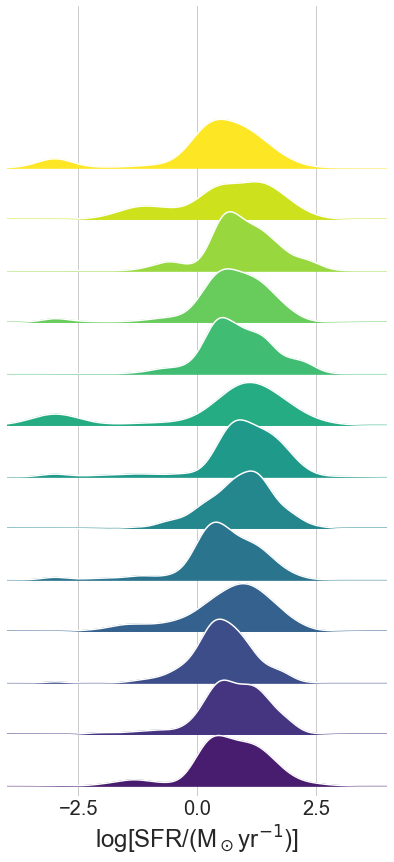

In [20]:
fig, axes = joypy.joyplot(data = z1_cat_sfr[z1_mask == 0],linecolor='w',ylabels=False, xlabelsize=20, ylabelsize=20,
                        figsize=(6,12),grid=True,yrot=0,colormap=matplotlib.cm.viridis_r)
for i in range(len(axes)):
    tempy = axes[i].set_ylim()
    axes[i].set_ylim(tempy[0],tempy[1]+1.0)
    axes[i].set_xlim(-4,4)
plt.xlabel(r'log[SFR/(M$_\odot$yr$^{-1}$)]')

plt.savefig("../figures/fig4_distrib_z1_sfr.png", dpi=600, bbox_inches='tight')

plt.show()

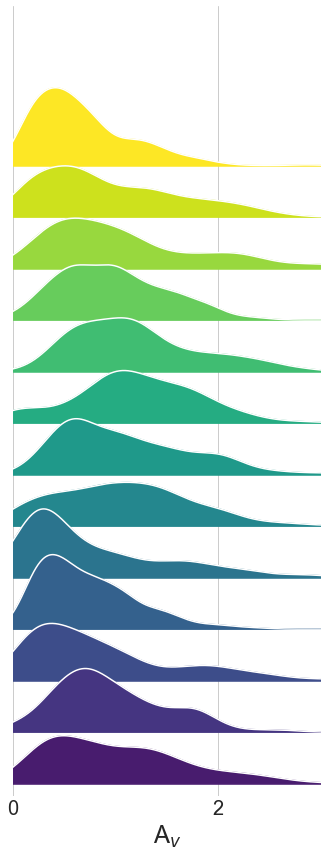

In [21]:
fig, axes = joypy.joyplot(data = z1_cat_Av[z1_mask == 0],linecolor='w',ylabels=False, xlabelsize=20, ylabelsize=20,
                        figsize=(5,12),grid=True,yrot=0,colormap=matplotlib.cm.viridis_r)
for i in range(len(axes)):
    tempy = axes[i].set_ylim()
    axes[i].set_ylim(tempy[0],tempy[1]+1.0)
    axes[i].set_xlim(0,3)
plt.xlabel(r'A$_v$')

plt.savefig("../figures/fig4_distrib_z1_av.png", dpi=600, bbox_inches='tight')


plt.show()